cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
            Conv2d-2         [-1, 32, 112, 112]           4,640
            Linear-3                  [-1, 128]      12,845,184
            Linear-4                   [-1, 32]           4,128
            Linear-5                    [-1, 4]             132
Total params: 12,854,532
Trainable params: 12,854,532
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 9.19
Params size (MB): 49.04
Estimated Total Size (MB): 58.80
----------------------------------------------------------------
Epoch [1/20], Train Loss: 1.2633, Train Accuracy: 50.52%
Epoch [2/20], Train Loss: 0.7597, Train Accuracy: 72.77%
Epoch [3/20], Train Loss: 0.5397, Train Accuracy: 82.20%
Epoch [4/20], Train Loss: 0.2979, Train Accuracy: 8

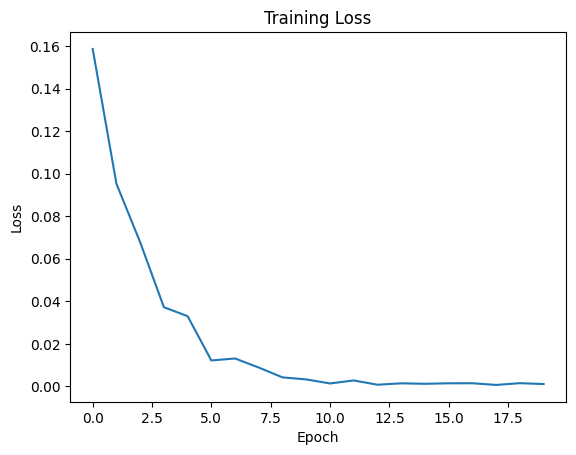

In [3]:
import os
import cv2
import torch
import os.path
import torchvision
import pandas as pd
import torch.nn as nn
import torchvision.io as io
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, default_collate
from torchvision.datasets import ImageFolder
from torchvision.io import ImageReadMode
from torchsummary import summary

# use CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

image_size = 224
batch_size = 8
num_classes = 4
num_epochs = 20

# function for read directury and label images
def label_images_in_directories(main_directory):
    label_names = []
    image_files = []
    for directory in os.listdir(main_directory):
        sub_directory = os.path.join(main_directory, directory)
        if os.path.isdir(sub_directory):
            for filename in os.listdir(sub_directory):
                image_file = os.path.join(sub_directory, filename)
                if os.path.isfile(image_file) and filename.endswith(".jpg"):
                    label_names.append(directory)
                    image_files.append(image_file)

    image_tensors = [torchvision.io.read_image(image, mode=ImageReadMode.UNCHANGED).to(torch.float32)/255 for image in image_files]
    nr_of_images = len(image_tensors)

    return label_names, image_tensors

train_dir = "./../../Project 3/data/Data_cleaning_step1_2/Train" # Data_cleaning_step1_2
label_names, image_tensors = label_images_in_directories(train_dir)

test_dir = "./../../Project 3/Data_cleaning_step1_2/Test" # /Data_cleaning_step1_2
label_names, image_tensors = label_images_in_directories(test_dir)

# Define the transformations before entering the neural network
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the images
])

# Load the training and test datasets
train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

# Create DataLoaders for managing the data batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes, image_size_nn):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * image_size_nn * image_size_nn, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Create an instance of the model
image_size_nn = int(image_size/4)
model = CNNModel(num_classes, image_size_nn)
model = model.to(device)
summary(model.to(device), input_size=(3,image_size,image_size))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
totalLoss = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    losses = []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        
    train_loss = train_loss / len(train_dataset)
    train_acc = (train_correct / len(train_dataset))*100
    totalLoss.append(sum(losses)/len(train_dataset))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

# Evaluate the model
model.eval()
test_correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

test_acc = (test_correct / len(test_dataset))*100
print(f"Test Accuracy: {test_acc:.2f}%")

# Save model
torch.save(model.state_dict(), "model_apple.pth")

data = {
    "Image Resize": str(image_size)+"*"+str(image_size),
    "Epochs": num_epochs,
    "Train Accuracy": train_acc,
    "Test Accuracy": test_acc,
    "Dataset use": os.path.basename(train_dir),
    "Model type": "Team model"
}

# Check if the CSV file already exists
if os.path.isfile("model_data.csv"):
    # Load existing data from CSV
    existing_data = pd.read_csv("model_data.csv")
    
    # Append new data to existing data
    new_data = pd.concat([existing_data, pd.DataFrame(data, index=[0])], ignore_index=True)
else:
    # Create a new DataFrame with the new data
    new_data = pd.DataFrame(data, index=[0])

# Save the updated DataFrame to CSV
new_data.to_csv("model_data.csv", index=False)



fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Loss', title="Training Loss")

plt.plot(totalLoss)
plt.show()
